<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

# Part 0 (Execute first!)

In [1]:
# Import packages
import warnings

import scipy
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

# Problem 4.2: Co-offending Network

## Preamble

In [6]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

# Set crime codes, counties and locations as categorical
categorical_vars = (['offender_id', 'sex', 'event_id'] 
                    + [f'crime{k}_code' for k in range(1,5)] 
                    + ['county', 'location'])
co_off[categorical_vars] = co_off[categorical_vars].astype('category')

In [ ]:
co_off.describe(include='all', datetime_is_numeric=True)

## (a), (b), (c), (d): Data exploration

This dataset contains 1,279,009 entries. Each observation is taken at the `offender_id`-`event_id` level, this is, individual offenders arrested at a given crime event.





In [48]:
co_off.shape[0]

1279009

Within, the number of unique offenders is 538,847, and the number of different crime events are 1,163,423, which occurred between 2003 and 2010 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 2003 |  122,281 |
| 2004 |  133,698 |
| 2005 |  188,007 |
| 2006 |  203,229 |
| 2007 |  213,995 |
| 2008 |  220,452 |
| 2009 |  197,340 |
| 2010 |        7 |

In [52]:
co_off[['offender_id', 'event_id']].describe(include='all')

,offender_id,event_id
count,1279009,1279009
unique,538847,1163423
top,300728,27849
freq,456,156


In [55]:
co_off[['offender_id', 'year']].groupby(['year']).count()

,offender_id
year,
2003,122281
2004,133698
2005,188007
2006,203229
2007,213995
2008,220452
2009,197340
2010,7


We can observe a total of 294 different crime codes (different offenses). And within each code there is high variability, with one of the crimes accounting for almost 140,000 of the observations (approximately 11% of the sample).

In [120]:
co_off['crime1_code'].describe()

count     1279009
unique        294
top          1430
freq       138549
Name: crime1_code, dtype: int64

In [82]:
group_by_code = co_off.groupby(['crime1_code'], as_index=False).count()

In [116]:
group_by_code['crime1_code']

0       1110
1       1120
2       1130
3       1140
4       1150
       ...  
289    92401
290    92402
291    93101
292    93102
293    93103
Name: crime1_code, Length: 294, dtype: category
Categories (294, int64): [1110, 1120, 1130, 1140, ..., 92402, 93101, 93102, 93103]

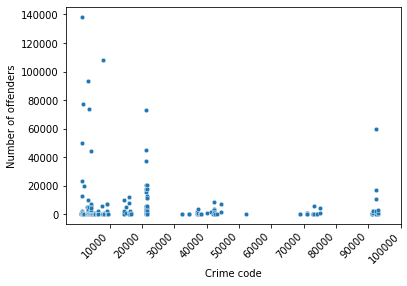

In [115]:
# Axis offsets
offset = (10,1000)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.scatterplot(data=group_by_code, x='crime1_code', y='offender_id', s=20, ax = ax)

# Set xticks
xticks = [1000 * k for k in range(1,11)]
xlabels = xticks

plt.xticks(ticks=xticks, labels=xlabels, rotation=45, horizontalalignment = 'right')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
# yticks = [20000 * k for k in range(8)]
# ylabels = yticks

# plt.yticks(yticks, ylabels)

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

Restricting the previous graph for crimes with less or equal than 20,000 events, only 280 of the 294 codes remain and the plot changes slightly

In [83]:
group_by_code[group_by_code['offender_id'] <= 20000].shape

(280, 14)

In [84]:
# Axis offsets
offset = (10,1000)

# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.histplot(data=group_by_code[group_by_code['offender_id'] <= 20000], x='crime1_code', y='offender_id', ax = ax)

# # Set xticks
xticks = [300/9 * k - 5 for k in range(10)]
xlabels = [1000 * k for k in range(1,11)]

plt.xticks(ticks=xticks, labels=xlabels, rotation=45, horizontalalignment = 'right')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [20000 * k for k in range(8)]
ylabels = yticks

plt.yticks(yticks, ylabels)

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

Error in callback <function flush_figures at 0x7fea41e02320> (for post_execute):


KeyboardInterrupt: ignored

## (b)

## (c)

## (d)

## (e)

## (f)

## (g)

## (h)

## (i)

## (j)

## (k)

## (l)

## (m)